# Video Game Genre Cluster to Rating Association System

## Program Setup

### Install Dependencies
This code cell installs the necessary dependencies for the Python script to run. Note that this generates a lot of output and may take a minute if having just launched a new JupyterLab instance.

In [169]:
%pip install opendatasets
%pip install pandas
%pip install matplotlib
%pip install mlxtend
%pip install ipywidgets

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


### Import Modules
This cell imports the necessary modules into the notebook.

In [170]:
import opendatasets as od
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import matplotlib.pyplot as plt
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
import ipywidgets
from IPython.display import Markdown, clear_output

### Download or Locate Dataset
If no dataset files are found in the local directory, it is re-downloaded from Kaggle. If the dataset is found, then this is skipped.

In [171]:
od.download("https://www.kaggle.com/datasets/nikdavis/steam-store-games")

Skipping, found downloaded files in ".\steam-store-games" (use force=True to force download)


### Import Dataset

In [172]:
games_df = pd.read_csv('steam-store-games/steam.csv')
display(games_df)

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price
0,10,Counter-Strike,2000-11-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,124534,3339,17612,317,10000000-20000000,7.19
1,20,Team Fortress Classic,1999-04-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,3318,633,277,62,5000000-10000000,3.99
2,30,Day of Defeat,2003-05-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Valve Anti-Cheat enabled,Action,FPS;World War II;Multiplayer,0,3416,398,187,34,5000000-10000000,3.99
3,40,Deathmatch Classic,2001-06-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,1273,267,258,184,5000000-10000000,3.99
4,50,Half-Life: Opposing Force,1999-11-01,1,Gearbox Software,Valve,windows;mac;linux,0,Single-player;Multi-player;Valve Anti-Cheat en...,Action,FPS;Action;Sci-fi,0,5250,288,624,415,5000000-10000000,3.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27070,1065230,Room of Pandora,2019-04-24,1,SHEN JIAWEI,SHEN JIAWEI,windows,0,Single-player;Steam Achievements,Adventure;Casual;Indie,Adventure;Indie;Casual,7,3,0,0,0,0-20000,2.09
27071,1065570,Cyber Gun,2019-04-23,1,Semyon Maximov,BekkerDev Studio,windows,0,Single-player,Action;Adventure;Indie,Action;Indie;Adventure,0,8,1,0,0,0-20000,1.69
27072,1065650,Super Star Blast,2019-04-24,1,EntwicklerX,EntwicklerX,windows,0,Single-player;Multi-player;Co-op;Shared/Split ...,Action;Casual;Indie,Action;Indie;Casual,24,0,1,0,0,0-20000,3.99
27073,1066700,New Yankee 7: Deer Hunters,2019-04-17,1,Yustas Game Studio,Alawar Entertainment,windows;mac,0,Single-player;Steam Cloud,Adventure;Casual;Indie,Indie;Casual;Adventure,0,2,0,0,0,0-20000,5.19


### Drop Unnessesary Tables, Drop Rows with Less Than 3 Genres or No Reviews

In [173]:
# Remove any rows that contain less than 3 genres and rows that don't have any reviews
games_df.drop(['appid', 'name', 'release_date', 'english', 'developer', 'publisher', 'platforms', 'required_age',
              'categories', 'genres', 'achievements', 'average_playtime', 'median_playtime', 'owners', 'price'], axis=1, inplace=True)
games_df = games_df[games_df["steamspy_tags"].apply(lambda x: len(x.split(
    ';')) == 3) & (games_df["positive_ratings"] | games_df["negative_ratings"])]


### Split the Genres Column into Three Distinct Columns

In [174]:
# Splits the Genres column into three distinct columns
games_df['genre_1'] = games_df['steamspy_tags'].apply(lambda x: x.split(';')[0])
games_df['genre_2'] = games_df['steamspy_tags'].apply(lambda x: x.split(';')[1])
games_df['genre_3'] = games_df['steamspy_tags'].apply(lambda x: x.split(';')[2])
games_df.drop('steamspy_tags', axis=1, inplace=True)
games_df

,positive_ratings,negative_ratings,genre_1,genre_2,genre_3
0,124534,3339,Action,FPS,Multiplayer
1,3318,633,Action,FPS,Multiplayer
3,1273,267,Action,FPS,Multiplayer
6,27755,1100,FPS,Classic,Action
7,12120,1439,Action,FPS,Multiplayer
...,...,...,...,...,...
27066,3,0,Early Access,Adventure,Sexual Content
27067,13,0,Early Access,Indie,Adventure
27070,3,0,Adventure,Indie,Casual
27071,8,1,Action,Indie,Adventure


In [175]:
# Create two Slider widgets
style = {'description_width': 'initial'}
rating_threshold_slider = ipywidgets.FloatSlider(
    value=0.75,
    min=0.05,
    max=0.950000001,
    step=0.05,
    description='Positive Rating Threshold',
    disabled=False,
    continuous_update=False,
    layout={'width': '400px'},
    style=style
)

weight_slider = ipywidgets.FloatSlider(
    value=0.001,
    min=0.001,
    max=0.01,
    step=0.0001,
    description='Rating Weight Threshold',
    disabled=False,
    continuous_update=False,
    readout_format='.4f',
    layout={'width': '400px'},
    style=style
)


### Define a Function that Returns "Positive" or "Negative" Given a Cutoff Value

In [176]:
def rating_from_value(value:float, cutoff:float):
    """Returns 'Positive' if the value is greater than or equal to the cutoff value, else returns 'Negative'."""
    if value >= cutoff:
        return "Positive"
    return "Negative"

### Calculate a Rating Ratio and Rating Weight

In [177]:
# Calculate a Rating Ratio based on the number of positive/negative ratings,
# and a Rating Weight based on the number of total ratings in an individual game compared
# to the highest number of total ratings for any game.
max_ratings = (games_df.positive_ratings + games_df.negative_ratings).max()
games_df['rating_ratio'] = (games_df.positive_ratings) / \
    (games_df.positive_ratings + games_df.negative_ratings)
games_df['rating_weight'] = (
    games_df.positive_ratings + games_df.negative_ratings) / (max_ratings)


## Positive/Negative Rating Ratios by Genre

In [178]:
display(Markdown(f'### Top 20 Most Occurring Genre Groups — Most-Reviewed Games'))
gbo = games_df[games_df["rating_weight"] >= weight_slider.value].groupby(['genre_1', 'genre_2', 'genre_3'])
display(gbo.size().sort_values(ascending=False)[:20])

### Top 20 Most Occurring Genre Groups — Most-Reviewed Games

genre_1       genre_2       genre_3              
Early Access  Survival      Open World               10
Action        FPS           Multiplayer               8
Free to Play  Action        Multiplayer               5
Strategy      RTS           Sci-fi                    4
FPS           Action        Sci-fi                    4
                            Co-op                     3
Free to Play  MMORPG        Massively Multiplayer     3
Survival      Open World    Multiplayer               3
RPG           Open World    Fantasy                   3
Anime         Fighting      Action                    3
Horror        Multiplayer   Survival Horror           3
              Singleplayer  Survival Horror           3
Free to Play  FPS           Action                    3
Early Access  Survival      Multiplayer               3
World War II  FPS           Multiplayer               3
Open World    Action        Multiplayer               3
Free to Play  Multiplayer   FPS                       

### Distribution of User Ratings Across Different Game Genres — All Games

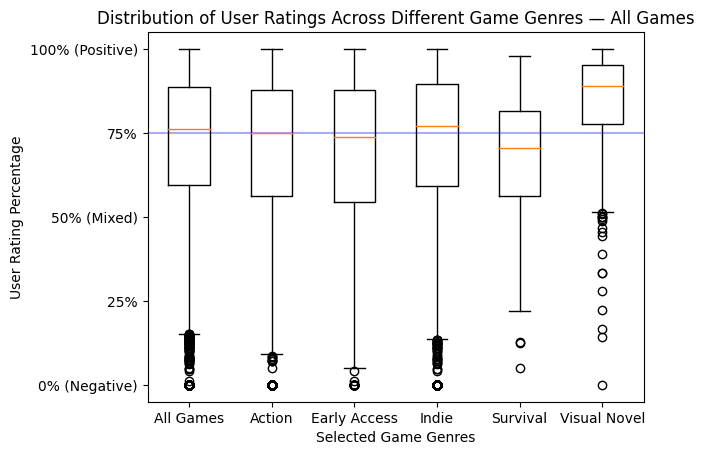

In [179]:
# Box Plot of the Distribution of User Ratings Across Different Game Genres across all Steam games.
plt.axhline(y=0.75, color='#AAAAFF', linestyle='-')
plt.boxplot([
    games_df["rating_ratio"],
    games_df.loc[((games_df["genre_1"] == 'Action') | (games_df["genre_2"] == 'Action') | (
        games_df["genre_3"] == 'Action'))]["rating_ratio"],
    games_df.loc[((games_df["genre_1"] == 'Early Access') | (games_df["genre_2"] ==
                  'Early Access') | (games_df["genre_3"] == 'Early Access'))]["rating_ratio"],
    games_df.loc[((games_df["genre_1"] == 'Indie') | (games_df["genre_2"] == 'Indie') | (
        games_df["genre_3"] == 'Indie'))]["rating_ratio"],
    games_df.loc[((games_df["genre_1"] == 'Survival') | (games_df["genre_2"]
                  == 'Survival') | (games_df["genre_3"] == 'Survival'))]["rating_ratio"],
    games_df.loc[((games_df["genre_1"] == 'Visaul Novel') | (games_df["genre_2"] ==
                  'Visual Novel') | (games_df["genre_3"] == 'Visual Novel'))]["rating_ratio"]
])
plt.xticks([1, 2, 3, 4, 5, 6], ['All Games', 'Action',
           'Early Access', 'Indie', 'Survival', 'Visual Novel'])
plt.title('Distribution of User Ratings Across Different Game Genres — All Games')
plt.xlabel("Selected Game Genres")
plt.ylabel("User Rating Percentage")
plt.yticks(ticks=[0.00, 0.25, 0.50, 0.75, 1.00], labels=[
           '0% (Negative)', '25%', '50% (Mixed)', '75%', '100% (Positive)'])
plt.show()


In [180]:
def calc_rating_table(rating_cutoff, weight_cutoff):
    """Calculates an interactive rating table and graph based on a Rating Cutoff and Weight Cutoff."""
    games_df['rating'] = games_df['rating_ratio'].apply(
        lambda x: rating_from_value(x, rating_cutoff))
    display(games_df[games_df["rating_weight"] >= weight_cutoff])

    # All Games Graph
    df = pd.DataFrame()
    df['p_count'] = pd.concat([games_df.loc[games_df.rating == 'Positive']['genre_1'],
                               games_df.loc[games_df.rating ==
                                            'Positive']['genre_2'],
                               games_df.loc[games_df.rating == 'Positive']['genre_3']]).value_counts()
    df['n_count'] = pd.concat([games_df.loc[games_df.rating == 'Negative']['genre_1'],
                               games_df.loc[games_df.rating ==
                                            'Negative']['genre_2'],
                               games_df.loc[games_df.rating == 'Negative']['genre_3']]).value_counts()
    df[:20].sort_values(by='p_count', ascending=True).plot.barh(
        color={"p_count": "#51C24E", "n_count": "#E32B41"})
    plt.legend(["Positive Ratings", "Negative Ratings"])
    plt.ylabel('Genres (by Positive Ratings)')
    plt.xlabel('Number of Genre Occurrences')
    plt.title(
        f'Positive/Negative Review Ratio Per Genre ({rating_cutoff * 100:.0f}% Threshold) — All Games')

    # Top Reviewed Games Graph
    df = pd.DataFrame()
    df['p_count'] = pd.concat([games_df[games_df["rating_weight"] >= weight_cutoff].loc[games_df.rating == 'Positive']['genre_1'],
                               games_df[games_df["rating_weight"] >=
                                        weight_cutoff].loc[games_df.rating == 'Positive']['genre_2'],
                               games_df[games_df["rating_weight"] >= weight_cutoff].loc[games_df.rating == 'Positive']['genre_3']]).value_counts()
    df['n_count'] = pd.concat([games_df[games_df["rating_weight"] >= weight_cutoff].loc[games_df.rating == 'Negative']['genre_1'],
                               games_df[games_df["rating_weight"] >=
                                        weight_cutoff].loc[games_df.rating == 'Negative']['genre_2'],
                               games_df[games_df["rating_weight"] >= weight_cutoff].loc[games_df.rating == 'Negative']['genre_3']]).value_counts()
    df[:20].sort_values(by='p_count', ascending=True).plot.barh(
        color={"p_count": "#46D4AD", "n_count": "#E32B71"})
    plt.legend(["Positive Ratings", "Negative Ratings"])
    plt.ylabel('Genres (by Positive Ratings)')
    plt.xlabel('Number of Genre Occurrences')
    plt.title(
        f'Positive/Negative Review Ratio Per Genre ({rating_cutoff * 100:.0f}% Threshold) — Most-Reviewed Games')


## Rating Comparison of Genres — All Games and Most-Reviewed

In [181]:
ipywidgets.interact(
    calc_rating_table, rating_cutoff=rating_threshold_slider, weight_cutoff=weight_slider)
pass

interactive(children=(FloatSlider(value=0.75, continuous_update=False, description='Positive Rating Threshold'…

### Distribution of User Ratings Across Different Game Genres — Most-Reviewed Games

In [182]:
display(Markdown(f'### Top 20 Most Highly-Rated Games — Most-Reviewed Games'))
display(games_df[games_df["rating_weight"] >= weight_slider.value].sort_values(by='rating_ratio', ascending=False)[:20])
display(Markdown(f'### Top 20 Most Poorly-Rated Games — Most-Reviewed Games'))
display(games_df[games_df["rating_weight"] >= weight_slider.value].sort_values(by='rating_ratio', ascending=True)[:20])

### Top 20 Most Highly-Rated Games — Most-Reviewed Games

,positive_ratings,negative_ratings,genre_1,genre_2,genre_3,rating_ratio,rating_weight,rating
18404,4114,53,Bullet Hell,Great Soundtrack,Difficult,0.987281,0.001368,Positive
23,138220,1891,Puzzle,Co-op,First-Person,0.986504,0.045988,Positive
7577,47918,723,Early Access,Base-Building,Resource Management,0.985136,0.015965,Positive
2290,14181,256,Action,Fast-Paced,Indie,0.982268,0.004739,Positive
4344,6578,123,Story Rich,Great Soundtrack,Pixel Graphics,0.981645,0.002199,Positive
7509,13889,277,Free to Play,Action,Fighting,0.980446,0.004650,Positive
4543,5745,115,Co-op,Puzzle,Local Co-Op,0.980375,0.001923,Positive
7399,10985,220,Story Rich,Pixel Graphics,Great Soundtrack,0.980366,0.003678,Positive
2036,14019,292,3D Platformer,Cute,Female Protagonist,0.979596,0.004697,Positive
17,51801,1080,Puzzle,First-Person,Singleplayer,0.979577,0.017357,Positive


### Top 20 Most Poorly-Rated Games — Most-Reviewed Games

,positive_ratings,negative_ratings,genre_1,genre_2,genre_3,rating_ratio,rating_weight,rating
1874,741,3134,Simulation,Space,Sci-fi,0.191226,0.001272,Negative
17933,1487,4620,Action,Open World,Hack and Slash,0.243491,0.002004,Negative
2695,1182,3585,Simulation,Building,Management,0.247955,0.001565,Negative
1903,954,2861,Hack and Slash,Action,RPG,0.250066,0.001252,Negative
21681,3093,8080,Sports,Basketball,Simulation,0.276828,0.003667,Negative
12826,4832,12067,Sports,Basketball,Gambling,0.285934,0.005547,Negative
879,971,2385,Strategy,City Builder,Medieval,0.289333,0.001102,Negative
2125,990,2101,Cyberpunk,RPG,Action,0.320285,0.001015,Negative
4635,1171,2461,Early Access,Casual,Open World,0.322412,0.001192,Negative
21463,8621,16359,Early Access,Survival,Open World,0.345116,0.008199,Negative


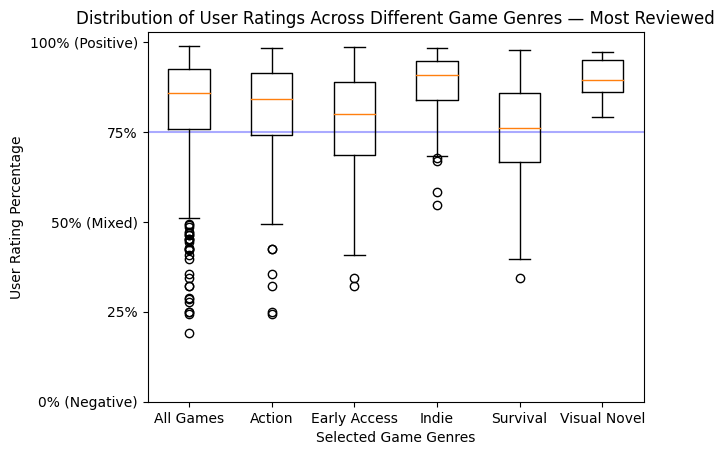

In [183]:
# Box Plot of the Distribution of User Ratings Across Different Game Genres across all Steam games.
plt.axhline(y=0.75, color='#AAAAFF', linestyle='-')
plt.boxplot([
    games_df[games_df["rating_weight"] >= weight_slider.value]["rating_ratio"],
    games_df[games_df["rating_weight"] >= weight_slider.value].loc[((games_df["genre_1"] == 'Action') | (
        games_df["genre_2"] == 'Action') | (games_df["genre_3"] == 'Action'))]["rating_ratio"],
    games_df[games_df["rating_weight"] >= weight_slider.value].loc[((games_df["genre_1"] == 'Early Access') | (
        games_df["genre_2"] == 'Early Access') | (games_df["genre_3"] == 'Early Access'))]["rating_ratio"],
    games_df[games_df["rating_weight"] >= weight_slider.value].loc[((games_df["genre_1"] == 'Indie') | (
        games_df["genre_2"] == 'Indie') | (games_df["genre_3"] == 'Indie'))]["rating_ratio"],
    games_df[games_df["rating_weight"] >= weight_slider.value].loc[((games_df["genre_1"] == 'Survival') | (
        games_df["genre_2"] == 'Survival') | (games_df["genre_3"] == 'Survival'))]["rating_ratio"],
    games_df[games_df["rating_weight"] >= weight_slider.value].loc[((games_df["genre_1"] == 'Visaul Novel') | (
        games_df["genre_2"] == 'Visual Novel') | (games_df["genre_3"] == 'Visual Novel'))]["rating_ratio"]
])
plt.xticks([1, 2, 3, 4, 5, 6], ['All Games', 'Action',
           'Early Access', 'Indie', 'Survival', 'Visual Novel'])
plt.title('Distribution of User Ratings Across Different Game Genres — Most Reviewed')
plt.xlabel("Selected Game Genres")
plt.ylabel("User Rating Percentage")
plt.yticks(ticks=[0.00, 0.25, 0.50, 0.75, 1.00], labels=[
           '0% (Negative)', '25%', '50% (Mixed)', '75%', '100% (Positive)'])
plt.show()


## Machine Learning Algorithm (Apriori-Based)

### One-Hot Encode the data for use with the Apriori Algorithm

In [184]:
# 
test_data = games_df[['genre_1', 'genre_2', 'genre_3', 'rating']]
te = TransactionEncoder()
te_array = te.fit(test_data[games_df["rating_weight"] >= weight_slider.value].values).transform(
    test_data[games_df["rating_weight"] >= weight_slider.value].values)
df = pd.DataFrame(te_array, columns=te.columns_)
df

,1980s,2D,2D Fighter,3D Platformer,4X,Action,Action RPG,Adventure,Agriculture,America,...,Video Production,Villain Protagonist,Violent,Visual Novel,Walking Simulator,War,Warhammer 40K,World War I,World War II,Zombies
0,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
946,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
947,False,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
948,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
949,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [185]:
def split_rating(genre_list) -> tuple:
    """Takes in a list of genres mixed with ratings and outputs a tuple containing ([genre_list], rating)."""
    gl = genre_list
    rating = "Negative"
    if "Positive" in gl:
        rating = "Positive"
        gl.remove("Positive")
    elif "Negative" in gl:
        gl.remove("Negative")
    return (gl, rating)

# Positive/Negative Association Counts by Genre

In [186]:
# Run the encoded data through the Apriori algorithm.
frequent_genres = apriori(df, min_support=0.0001, use_colnames=True)

# Apply a temporary length value to each row, then drop any rows that don't have a length of 4.
frequent_genres['length'] = frequent_genres['itemsets'].apply(lambda x: len(x))
frequent_genres = frequent_genres[frequent_genres['length'] == 4]
frequent_genres.drop('length', axis=1, inplace=True)

# Split the associated items in the frozenset back into individual columns.
frequent_genres['itemsets'] = frequent_genres['itemsets'].apply(lambda x: sorted(list(x)))
frequent_genres['rating'] = frequent_genres['itemsets'].apply(lambda x: split_rating(x)[1])
frequent_genres['genre_1'] = frequent_genres['itemsets'].apply(lambda x: split_rating(x)[0][0])
frequent_genres['genre_2'] = frequent_genres['itemsets'].apply(lambda x: split_rating(x)[0][1])
frequent_genres['genre_3'] = frequent_genres['itemsets'].apply(lambda x: split_rating(x)[0][2])
frequent_genres.drop('itemsets', axis=1, inplace=True)

In [187]:
display(Markdown(f'### Most Confident Positively-Associated Genre Groups ({rating_threshold_slider.value * 100:.0f}% Positivity Threshold):'))
display(frequent_genres[frequent_genres['rating'] == 'Positive'].sort_values(by=['support', 'genre_1', 'genre_2', 'genre_3'], ascending=False)[:20])

### Most Confident Positively-Associated Genre Groups (75% Positivity Threshold):

,support,rating,genre_1,genre_2,genre_3
3650,0.009464,Positive,Action,FPS,Multiplayer
3917,0.006309,Positive,Casual,Indie,Puzzle
3749,0.006309,Positive,Action RPG,Hack and Slash,RPG
3615,0.006309,Positive,Action,Co-op,FPS
4195,0.005258,Positive,Indie,Platformer,Puzzle
4184,0.005258,Positive,Horror,Singleplayer,Survival Horror
4053,0.005258,Positive,Early Access,Open World,Survival
3677,0.005258,Positive,Action,Free to Play,Multiplayer
4310,0.004206,Positive,Racing,Simulation,Sports
4088,0.004206,Positive,Fantasy,Open World,RPG


In [188]:
display(Markdown(f'### Most Confident Negatively-Associated Genre Groups ({rating_threshold_slider.value * 100:.0f}% Positivity Threshold):'))
display(frequent_genres[frequent_genres['rating'] == 'Negative'].sort_values(by=['support', 'genre_1', 'genre_2', 'genre_3'], ascending=False)[:20])

### Most Confident Negatively-Associated Genre Groups (75% Positivity Threshold):

,support,rating,genre_1,genre_2,genre_3
4050,0.006309,Negative,Early Access,Open World,Survival
4116,0.005258,Negative,Free to Play,MMORPG,Massively Multiplayer
4247,0.003155,Negative,Multiplayer,Open World,Survival
4180,0.003155,Negative,Horror,Multiplayer,Survival Horror
4043,0.003155,Negative,Early Access,Multiplayer,Survival
3649,0.003155,Negative,Action,FPS,Multiplayer
4272,0.002103,Negative,RTS,Strategy,World War II
4265,0.002103,Negative,Open World,Sandbox,Survival
4251,0.002103,Negative,Multiplayer,Survival,Zombies
4245,0.002103,Negative,Multiplayer,Open World,Racing


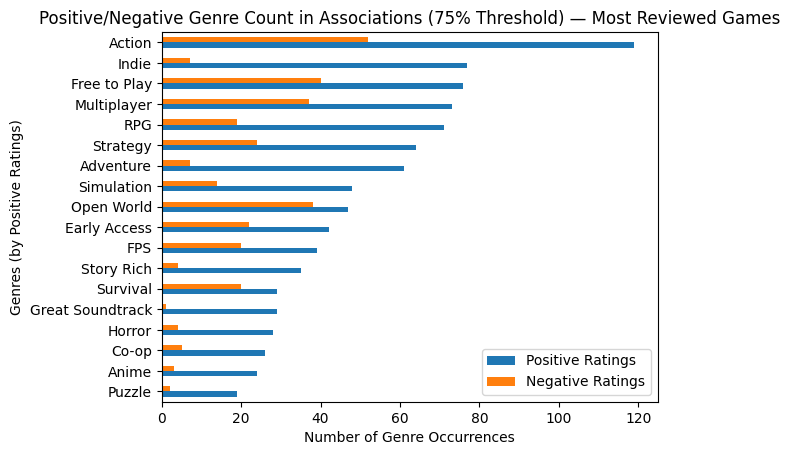

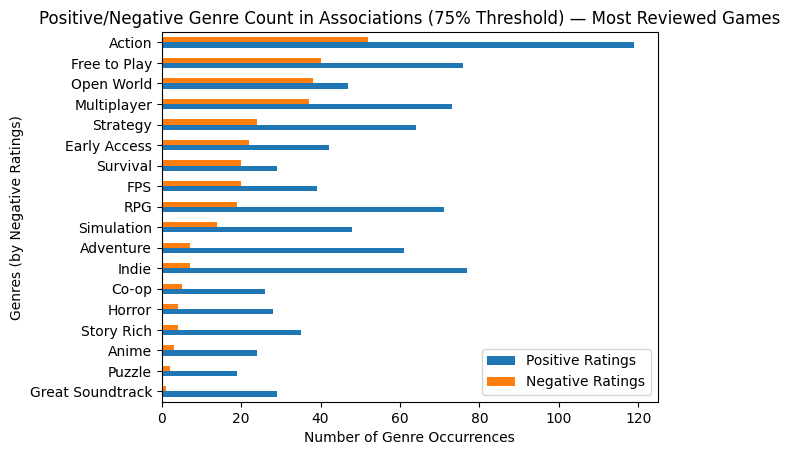

In [189]:
# Create a dataframe consisting of the positive and negative review counts per genre.
df = pd.DataFrame()

df['p_count'] = pd.concat([frequent_genres.loc[frequent_genres.rating == 'Positive']['genre_1'],
                         frequent_genres.loc[frequent_genres.rating == 'Positive']['genre_2'],
                         frequent_genres.loc[frequent_genres.rating == 'Positive']['genre_3']]).value_counts()
df['n_count'] = pd.concat([frequent_genres.loc[frequent_genres.rating == 'Negative']['genre_1'],
                         frequent_genres.loc[frequent_genres.rating == 'Negative']['genre_2'],
                         frequent_genres.loc[frequent_genres.rating == 'Negative']['genre_3']]).value_counts()

df[:20].sort_values(by='p_count', ascending=True).dropna(subset=['n_count']).plot.barh()
plt.legend(["Positive Ratings", "Negative Ratings"])
plt.ylabel('Genres (by Positive Ratings)')
plt.xlabel('Number of Genre Occurrences')
plt.title(f'Positive/Negative Genre Count in Associations ({rating_threshold_slider.value * 100:.0f}% Threshold) — Most Reviewed Games')

df[:20].sort_values(by='n_count', ascending=True).dropna(subset=['n_count']).plot.barh()
plt.legend(["Positive Ratings", "Negative Ratings"])
plt.ylabel('Genres (by Negative Ratings)')
plt.xlabel('Number of Genre Occurrences')
plt.title(f'Positive/Negative Genre Count in Associations ({rating_threshold_slider.value * 100:.0f}% Threshold) — Most Reviewed Games')
pass

In [190]:
def agg_third_genres(table, genre_1, genre_2):
    """Takes in a Pandas DataFrame and returns a list of aggregated final genre objects."""
    genre_objects = []
    for index, row in table.iterrows():
        gcol = 'genre_1'
        if row['genre_1'] == genre_1:
            gcol = 'genre_2' if row['genre_2'] != genre_2 else 'genre_3'
        elif row['genre_1'] == genre_2:
            gcol = 'genre_2' if row['genre_2'] != genre_1 else 'genre_3'

        new_go = {'name': row[gcol], 'support': (float(
            row['support']) * -1) if row['rating'] == 'Negative' else float(row['support'])}
        if genre_objects:
            for go in genre_objects:
                if new_go['name'] != go['name'] and new_go not in genre_objects:
                    genre_objects.append(new_go)
                else:
                    go['support'] += new_go['support']
        else:
            genre_objects.append(new_go)

    return sorted(genre_objects, key=lambda x: x['support'], reverse=True)

In [191]:
def update_selection_markdown(genre_1, genre_2):
    """Recalculate the options available for the Second Genre."""
    genre_1_present = frequent_genres.loc[(frequent_genres["genre_1"] == genre_1) | (
        frequent_genres["genre_2"] == genre_1) | (frequent_genres["genre_3"] == genre_1)]
    second_selection = pd.concat(
        [genre_1_present['genre_1'], genre_1_present['genre_2'], genre_1_present['genre_3']]).unique().tolist()
    second_selection.remove(genre_1)
    second_dropdown.options = sorted(second_selection)

    third_row_options = frequent_genres.loc[((frequent_genres["genre_1"] == genre_1) | (frequent_genres["genre_2"] == genre_1) | (frequent_genres["genre_3"] == genre_1)) & (
        (frequent_genres["genre_1"] == genre_2) | (frequent_genres["genre_2"] == genre_2) | (frequent_genres["genre_3"] == genre_2))].sort_values(by='support', ascending=True)

    clear_output()

    final_selection_list = agg_third_genres(
        third_row_options, genre_1, genre_2)
    if not final_selection_list:
        final_selection_list.append({'name': 'N/A', 'support': 0.0})

    rating_str = 'Positive' if final_selection_list[0]["support"] > 0 else 'Negative'
    rating_str = 'Neutral' if final_selection_list[0]["support"] == 0.0 else rating_str
    display(Markdown(
        f'Two Chosen Genres: **{genre_1}, {genre_2}**\n\nBest Prescriptive Third Genre: **{final_selection_list[0]["name"]}!**\n\n**{rating_str}** Rating Association with **{rating_threshold_slider.value * 100:.0f}%+** {rating_str} Rating Threshold *(Support Value: {final_selection_list[0]["support"]:.4f})*'))
    display(Markdown('*Full Association Table for Choices:*'))
    display(pd.DataFrame(final_selection_list).sort_values(by='support', ascending=False))

In [192]:
# Define the dropdown widgets for the Genre Group Selector.
first_dropdown = ipywidgets.Dropdown(
    options=[''],
    value='',
    description='First Genre:',
    disabled=False,
    style=style
)

second_dropdown = ipywidgets.Dropdown(
    options=[''],
    value='',
    description='Second Genre:',
    disabled=False,
    style=style
)

In [193]:
# Create a list of all unique genres in the reduced dataset.
all_genres = pd.concat([frequent_genres['genre_1'],
                       frequent_genres['genre_2'], frequent_genres['genre_3']]).unique()

# Assign all genres as options to the two dropdowns.
first_dropdown.options = all_genres
second_dropdown.options = all_genres

display(Markdown('## Optimized Genre Group Selector'))
display(Markdown(
    '#### *Please reselect the Second Genre after selecting a new First Genre.*'))
ipywidgets.interact(update_selection_markdown,
                    genre_1=first_dropdown, genre_2=second_dropdown)
pass


## Optimized Genre Group Selector

#### *Please reselect the Second Genre after selecting a new First Genre.*

interactive(children=(Dropdown(description='First Genre:', options=('1980s', '2D', '2D Fighter', '3D Platforme…